# Forecast a time series with ARIMA in Python

In this notebook, you'll perform a time series analysis using the Autoregressive Integrated Moving Average (ARIMA) modeling technique in Python. ARIMA modeling, in theory, is the most general class of models for forecasting a time series. 

A time series is a collection of data points that are collected at constant time intervals. What differentiates a time series from regular regression problem data is that the observations are time dependent and, along with an increasing or decreasing trend, many time series exhibit seasonal trends. The ARIMA technique seeks to model these trends in data over time and then extrapolate into the future to obtain forecasts. Time series modeling is a powerful method to derive insights from time-based data and make informed decisions about future trends.

In this notebook, you will analyze data from <a href="https://www.quandl.com/data/BOE/XUDLERD-Spot-Exchange-Rate-Euro-Into-USD" target="_blank" rel="noopener noreferrer">Quandl</a>. The data describes the Bank of England's official statistics on spot exchange rates for the Euro into US dollars (USD). More information on the the data source and Euro exchange rates prior to 1999 can be found <a href="http://www.bankofengland.co.uk/statistics/pages/iadb/notesiadb/Spot_rates.aspx" target="_blank" rel="noopener noreferrer">here</a>. 

Familiarity with Python is recommended. This notebook runs on Python 2 with Spark 2.0.

Before you begin with the forecasting steps, you might want to review the following articles that cover the fundamental concepts about time series modeling:

1. <a href="https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/" target="_blank" rel="noopener noreferrer">A complete tutorial on time series modeling in R</a>
2. <a href="https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/" target="_blank" rel="noopener noreferrer">Time series forecasting with codes in Python</a>
3. <a href="http://people.duke.edu/~rnau/411home.htm" target="_blank" rel="noopener noreferrer">Statistical forecasting: notes on regression and time series analysis</a>

## Table of Contents

1. [Get data](#get_data)
2. [Load libraries](#load_libraries)
3. [Load and visualize time series data](#load_data)
4. [Stationarize the time series](#stationarize_data)
5. [Find optimal parameters and build ARIMA model](#model_tuning)
6. [Perform and visualize time series forecasting](#forecast)
7. [Summary](#summary)


<a id="get_data"></a>
## 1. Get data

To get the data set that contains the Bank of England's official statistics on spot exchange rates for Euro into USD:

1. Go to <a href="https://www.quandl.com/data/BOE/XUDLERD-Spot-Exchange-Rate-Euro-Into-USD" target="_blank" rel="noopener noreferrer">Quandl</a> and then download the the CSV file named BOE-XUDLERD.csv.
   To complete the file download, you must sign up to Quandl. Enter new credentials or use your existing Git or LinkedIn account. 
    
2. Save the CSV files to your computer.


<a id="load_libraries"></a>
## 2. Load libraries

Run the following code to install the libraries that you need when you begin with the forecasting steps:

In [2]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

<a id="load_data"></a>
## 3. Load and visualize time series data

### 3.1 Load the data

Load the BOE-XUDLERD.csv file into your notebook by clicking the <b>Find and Add Data</b> icon on the notebook action bar. Drop the file into the box or browse to select the file. The file is loaded to your object storage and appears in the Data Assets section of the project.

To load the data from the BOE-XUDLERD.csv file containing trends about Euro spot exchange rates against USD into a pandas DataFrame, click in the next code cell and select <b>Insert to code > pandas DataFrame</b> under the file name.

<b>Note</b>: The DataFrame that is created for you and filled with data is given a generic name (`df_data_1`). Rename the DataFrame to `df_fx_data` and run the code cell to proceed.


Run the following to convert the Pandas DataFrame into a time series with daily frequency:

In [4]:
df_fx_data['Date'] = pd.to_datetime(df_fx_data['Date'])
indexed_df = df_fx_data.set_index('Date')

Show the first 5 rows:

In [5]:
ts = indexed_df['Value']
ts.head(5)

Date
2017-03-24    0.9255
2017-03-23    0.9270
2017-03-22    0.9258
2017-03-21    0.9252
2017-03-20    0.9300
Name: Value, dtype: float64

### 3.2 Visualize the raw data

Visualize the time series to see how the Euro is trending against the US dollar over time:

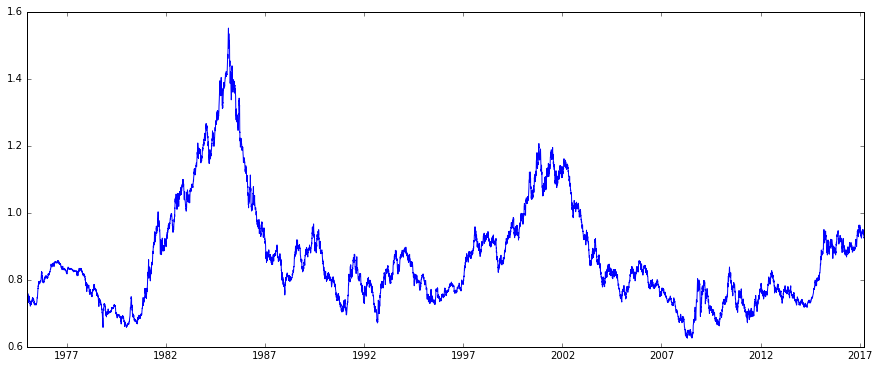

In [6]:
plt.plot(ts)

### 3.3 Resample the data

Using daily data for your time series contains too much variation, so you must first resample the time series data by week. Then use this resampled time series to predict the Euro exchange rates against the US Dollar:

In [7]:
ts_week = ts.resample('W').mean()

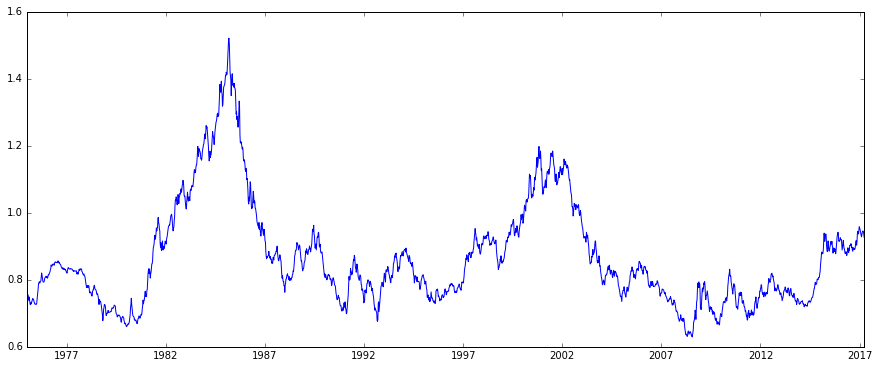

In [8]:
plt.plot(ts_week)

### 3.4 Check for stationarity

What is meant by checking the stationarity of a time series and why do you care about it?

In a stationary time series, the statistical properties over time must be constant and autoconvariance must be time independent. Normally, when running a regular regression, you expect the observations to be independent of each other. In a time series, however, you know that the observations are time dependent. In order to use regression techniques on time dependent variables, the data must be stationary. The techniques that apply to independent random variables also apply to stationary random variables.

There are two ways to check the stationarity of a time series. The first is plot the moving variance and observe if it remains constant over time. However, you might not always be able to make such visual inferences. The second way is to use the Dickey-Fuller test, a statistical test with the null hypothesis that the time series is non-stationary. If the test results in the test statistic significantly less than the critical values, we can reject the null hypothesis in favor of time series stationarity.

Calculate the moving variances, plot the results and apply the Dickey-Fuller test on the time series:

In [9]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

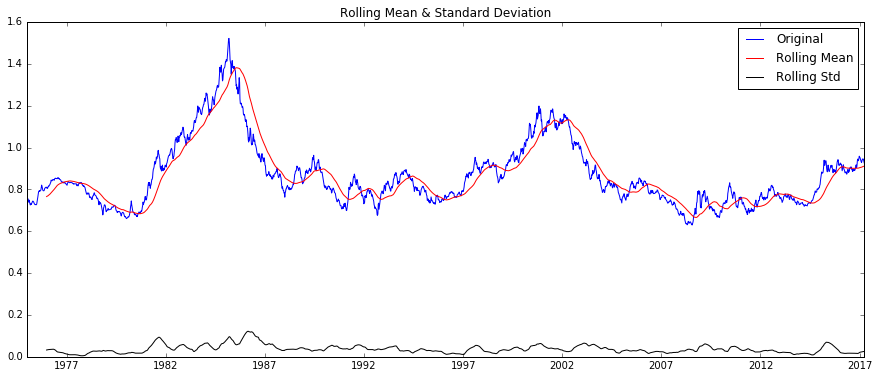

Results of Dickey-Fuller Test:
Test Statistic                   -2.037007
p-value                           0.270586
#Lags Used                        2.000000
Number of Observations Used    2201.000000
Critical Value (5%)              -2.862854
Critical Value (1%)              -3.433325
Critical Value (10%)             -2.567470
dtype: float64


In [10]:
test_stationarity(ts_week)

Because the test statistic is more than the 5% critical value and the p-value is larger than 0.05, the moving average is not constant over time and the null hypothesis of the Dickey-Fuller test cannot be rejected. This shows that the weekly time series is not stationary. 

Before you can apply ARIMA models for forecasting, you need to transform this time series into a stationary time series.

<a id="stationarize_data"></a>
## 4. Stationarize the time series

If your time series reveals a trend or seasonality, this is an indication that it is non-stationary. You can stationarize the time series by calculating the trend and seasonality and removing these factors from the model. You can apply different transformations to stationarize your data as seen in this list <a href="http://people.duke.edu/~rnau/whatuse.htm" target="_blank" rel="noopener noreferrer">here</a>.

### 4.1 Apply a nonlinear log transformation

Begin by applying a simple, nonlinear log transformation and checking for stationarity: 

In [11]:
ts_week_log = np.log(ts_week)

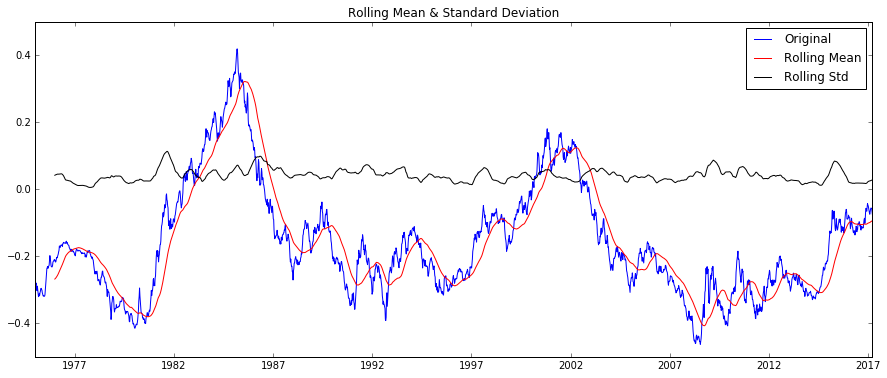

Results of Dickey-Fuller Test:
Test Statistic                   -2.189216
p-value                           0.210183
#Lags Used                        1.000000
Number of Observations Used    2202.000000
Critical Value (5%)              -2.862853
Critical Value (1%)              -3.433323
Critical Value (10%)             -2.567469
dtype: float64


In [12]:
test_stationarity(ts_week_log)

The Dickey-Fuller test results confirm that the series is still non-stationary. Again the test statistic is larger than the 5% critical value and the p-value larger than 0.05.

### 4.2 Remove trend and seasonality with decomposition

Next, decompose the time series to remove trend and seasonality from the data. Decomposition results show an increasing trend and seasonal effect of approximately a 12 month cycle for the more recent weeks in the data set. 

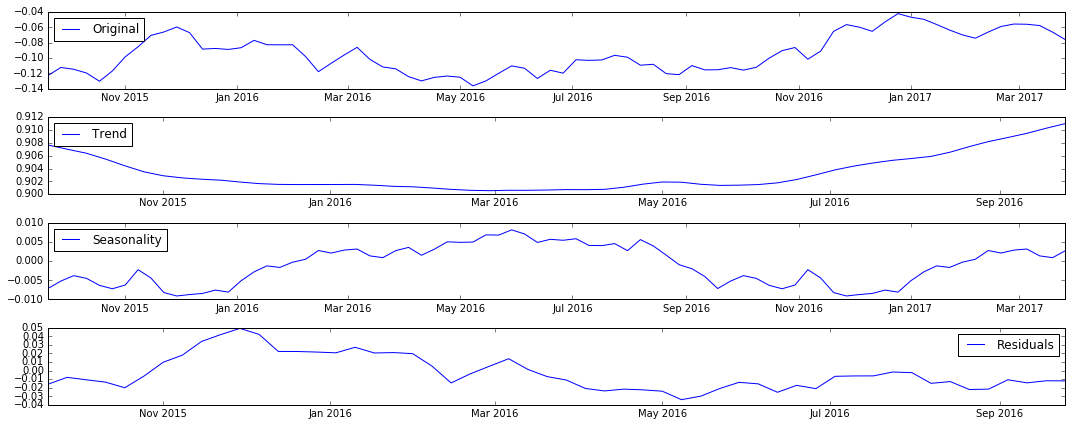

In [13]:
decomposition = seasonal_decompose(ts_week)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_week_log[-80:], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend[-80:], label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal[-80:],label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual[-80:], label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


Now that you have stationarized your time series, you could go on and model residuals (fit lines between values in the plot). However, as the patterns for the trend and seasonality information extracted from the series that are plotted after decomposition are still not consistent and cannot be scaled back to the original values, you cannot use this approach to create reliable forecasts. 

In case your time series does show a strong and consistent seasonal trend,  <a href="http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/" target="_blank" rel="noopener noreferrer">here</a> is a good article that describes the use of the <a href="http://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html" target="_blank" rel="noopener noreferrer">SARIMAX</a> model in Python.

### 4.3 Remove trend and seasonality with differencing

Differencing is one of the most common methods of dealing with both trend and seasonality. In first order differencing, you compute the differences between consecutive observations in the time series. This usually improves the stationarity of the time series. In the code, this is confirmed by running the Dickey-Fuller test. 

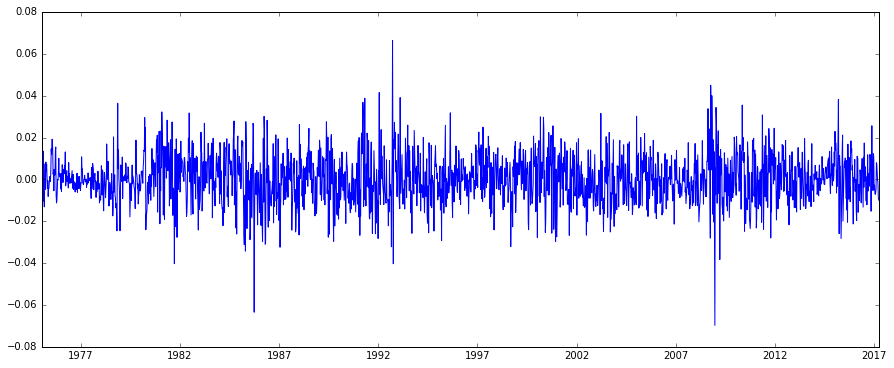

In [14]:
ts_week_log_diff = ts_week_log - ts_week_log.shift()
plt.plot(ts_week_log_diff)

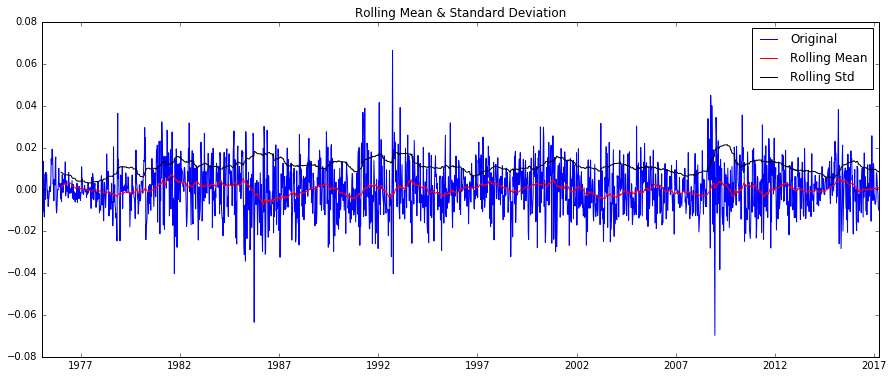

Results of Dickey-Fuller Test:
Test Statistic                  -36.330494
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2202.000000
Critical Value (5%)              -2.862853
Critical Value (1%)              -3.433323
Critical Value (10%)             -2.567469
dtype: float64


In [15]:
ts_week_log_diff.dropna(inplace=True)
test_stationarity(ts_week_log_diff)

The results show that the test statistic is significantly less than the 1% critical value. 

This shows you that your time series is now stationary with 99% confidence. Now you can begin to apply statistical models like ARIMA to forecast future Euro exchange rates using this stationarized time series.

<a id="model_tuning"></a>
## 5. Find optimal parameters and build an ARIMA model

To apply an ARIMA model to your time series, you need to find optimal values for the following three model parameters (p,d,q):

- The number of autoregressive (AR) terms (p): AR terms are just lags of the dependent variable, the euro rate, in this case. So, if p=2, it means that predictors of x(t) will be x(t-1) and x(t-2).
- The number of moving average (MA) terms (q): MA terms are lagged forecast errors in the prediction equation. For instance, if q=2, the predictors for x(t) will be e(t-1) and e(t-2) where e(i) is the difference between the moving average at i-th instant and the actual value.
- The number of differences (d): These are the number of non-seasonal differences. In your case, d=1, as you are modeling  using the first order differenced time series.


There are two ways to determine the number of AR and MA terms. The first is to use the <a href="http://statsmodels.sourceforge.net/0.6.0/generated/statsmodels.tsa.stattools.arma_order_select_ic.html" target="_blank" rel="noopener noreferrer">arma_order_select_ic</a> function in Python. The second uses plots of the autocorrelation function (ACF) and partial autocorrelation function (PACF).

This <a href="http://people.duke.edu/~rnau/411arim3.htm" target="_blank" rel="noopener noreferrer">article</a> describes in detail the purpose of the ACF and PACF plots.

### 5.1 Plot the autocorrelation function (ACF) and partial autocorrelation function (PACF)

Run the next cell to plot the ACF and PACF, and determine the `p`, `d` and `q` model parameters which you will need later as input for the ARIMA model:

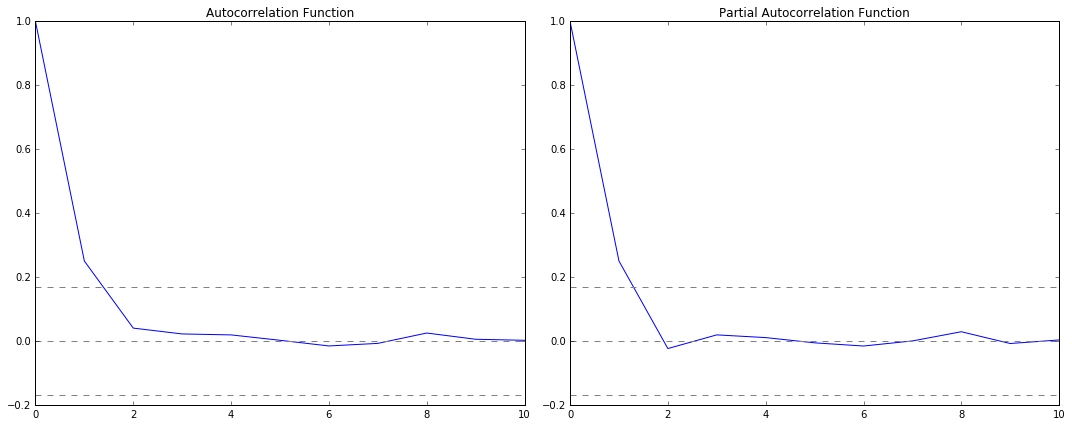

In [16]:
#ACF and PACF plots

lag_acf = acf(ts_week_log_diff, nlags=10)
lag_pacf = pacf(ts_week_log_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


In this plot, the 'p' and 'q' values can be determined as follows:

-  `p`: The lag value where the PACF cuts off (drops to 0) for the first time. If you look closely, `p=2`.
-  `q`: The lag value where the ACF chart crosses the upper confidence interval for the first time. If you look closely, `q=1`.

This means that the optimal values for the ARIMA(p,d,q) model are (2,1,1). 

If your assessment of the ACF and PACF plots differs from the values suggested by the arma_order_select_ic function, you should plug in different values for the p and q terms and use the model fit results to study the <a href="https://coolstatsblog.com/2013/08/14/using-aic-to-test-arima-models-2/" target="_blank" rel="noopener noreferrer">AIC</a> values and proceed with the model with a lower AIC value

Run the next code cell to plot the ARIMA model using the values (2,1,1):

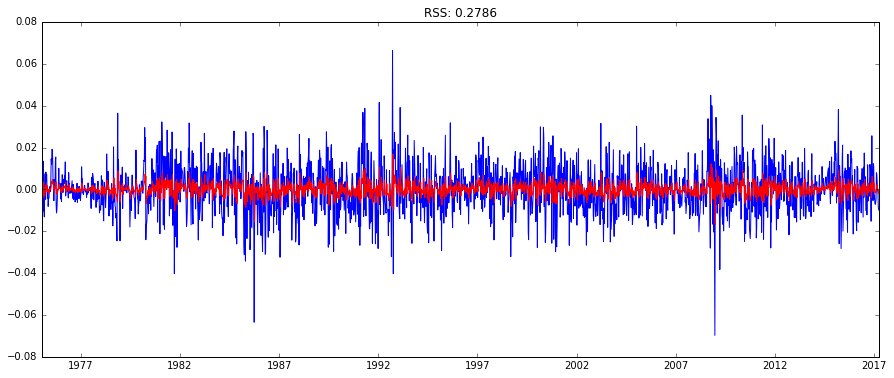

In [17]:
model = ARIMA(ts_week_log, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_week_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_week_log_diff)**2))

### 5.2 Measure the variance between the data and the values predicted by the model

You can measure whether the results of your model fit the underlying data by using the residual sum of squares (RSS) metric. A small RSS indicates that the model fits tightly to the data. 

Yet another approach to validate the ARIMA model appropriateness is by performing residual analysis. 

Print the results of the ARIMA model and plot the residuals. A density plot of the residual error values indicates a normal distribution centered around zero mean. Also, the residuals do not violate the assumptions of constant location and scale with most values in the range (-1,1). 

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 2203
Model:                 ARIMA(2, 1, 1)   Log Likelihood                6760.785
Method:                       css-mle   S.D. of innovations              0.011
Date:                Thu, 06 Apr 2017   AIC                         -13511.571
Time:                        13:23:25   BIC                         -13483.083
Sample:                    01-12-1975   HQIC                        -13501.162
                         - 03-26-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.672e-05      0.000      0.277      0.782      -0.001       0.001
ar.L1.D.Value    -0.0869      0.507     -0.171      0.864      -1.081       0.907
ar.L2.D.Value     0.0602      0.133     

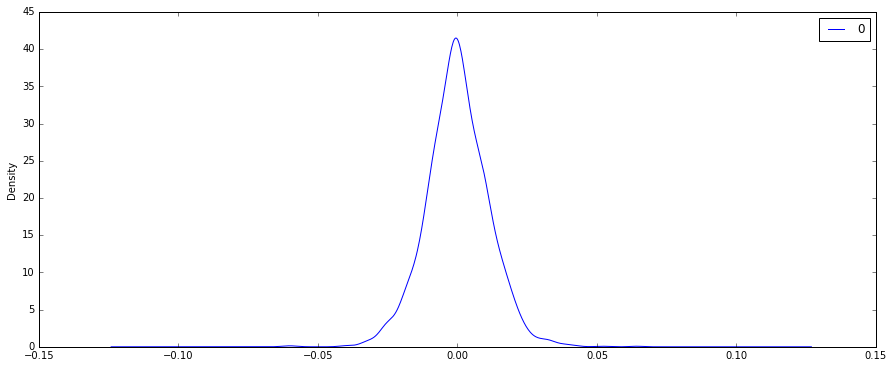

In [18]:
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())


The model validation checks you ran have confirmed good results.

### 5.3 Scale predictions

Now that the model is returning the results you want to see, you can scale the model predictions back to the original scale. For this, you will remove the first order differencing and take exponent to restore the predictions back to their original scale.

The lower the root mean square error (RMSE) and the closer it is to 0, the better are the model predictions in being closer to actual values.

In [19]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

Date
1975-01-12    0.000087
1975-01-19   -0.002392
1975-01-26    0.000999
1975-02-02   -0.004059
1975-02-09   -0.001128
Freq: W-SUN, dtype: float64


In [20]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_week_log.ix[0], index=ts_week_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

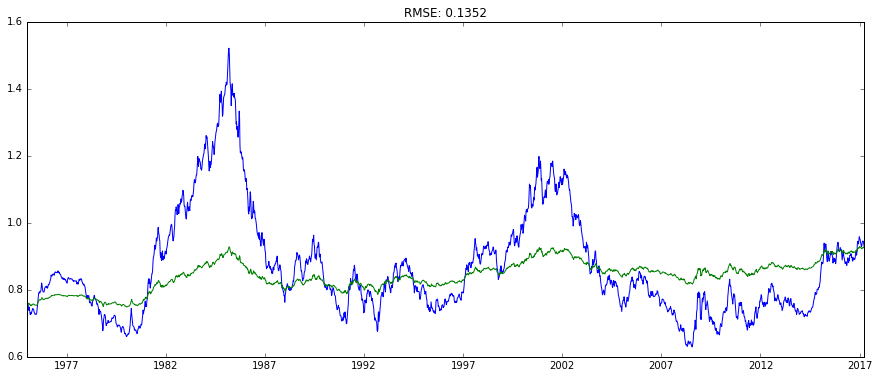

In [21]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_week)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_week)**2)/len(ts_week)))

The RMSE is close enough to 0: the model predictions are accurate.

<a id="forecast"></a>
## 6. Perform and visualize time series forecasting

What you have achieved in this notebook so far is in-sample forecasting using ARIMA as you trained the model on the entire time series data. Now you need to split the data set into a training and testing data sets. You will use the training data set to train the ARIMA model and perform out-of-sample forecasting. Then you will compare the results of your out-of-sample predictions for Euro rates with the actual values from the test data set.

You will use the forecast function <a href="http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.arima_model.ARIMAResults.forecast.html" target="_blank" rel="noopener noreferrer">forecast</a> and perform a rolling one-step forecast with ARIMA. A rolling forecast is required given the dependence on observations during differencing and the AR model. You will re-create the ARIMA model after each new prediction is received. And you will  manually keep track of all observations in a list called history, which is seeded with the training data and to which new predictions are appended in each iteration.


In [22]:
size = int(len(ts_week_log) - 15)
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

error = mean_squared_error(test, predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

predictions_series = pd.Series(predictions, index = test.index)

Printing Predicted vs Expected Values...


predicted=0.935742, expected=0.948440
predicted=0.951603, expected=0.958640
predicted=0.960984, expected=0.954200
predicted=0.952981, expected=0.951600
predicted=0.951187, expected=0.945180
predicted=0.943624, expected=0.938440
predicted=0.936961, expected=0.932520
predicted=0.931199, expected=0.928520
predicted=0.927680, expected=0.935940
predicted=0.937989, expected=0.942780
predicted=0.944376, expected=0.945760
predicted=0.946485, expected=0.945500
predicted=0.945459, expected=0.943900
predicted=0.943582, expected=0.935900
predicted=0.933961, expected=0.926700


Printing Mean Squared Error of Predictions...
Test MSE: 0.000042


You validated the model by comparing its out-of-sample predictions for Euro rates with actual values from the test data set and calculating the mean squared error. Now plot the rolling forecast predictions against the observed values. You will see that the predictions are in the correct scale and are picking up the trend in the original time series.


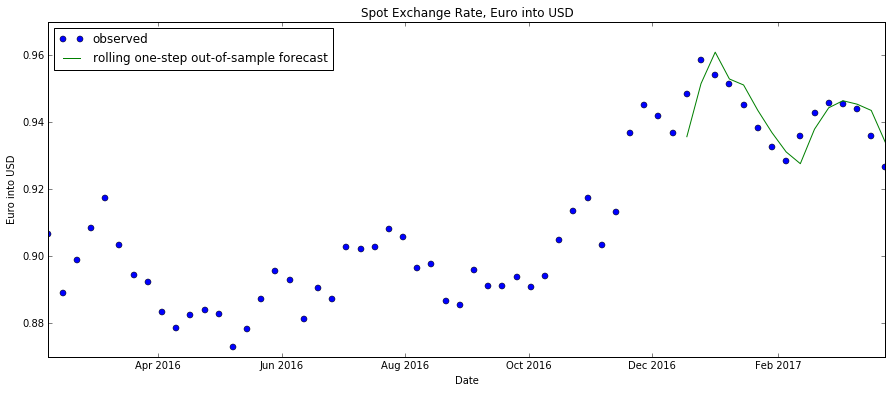

In [23]:
fig, ax = plt.subplots()
ax.set(title='Spot Exchange Rate, Euro into USD', xlabel='Date', ylabel='Euro into USD')
ax.plot(ts_week[-60:], 'o', label='observed')
ax.plot(np.exp(predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')

<a id="summary"></a>
## 7. Summary

In this Python notebook, you learned how to load and visualize a time series, check the stationarity of the time series and apply transformations to the time series to make it stationary. You learned how to find the optimal values for the parameters in the ARIMA model and how to use the model for in-sample and out-of-sample predictions.

### Authors

**Anjali Shah**, PhD is a data scientist at IBM Analytics, specializing in machine learning and big data analytics using Apache Spark and Hadoop. She has deep expertise in learning and applying cutting edge technology to analyze structured and unstructured data that has helped convert data into actionable business insights 

Some of the code used in this notebook was contributed by <a href="https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/" target="_blank" rel="noopener noreferrer">**Aarshay Jain**</a> and <a href="http://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/" target="_blank" rel="noopener noreferrer">**Jason Brownlee**</a>.

### <a id="citations"></a>Data citations

Financial data on the Euro to Dollar exchange rate provided by <a href="https://www.quandl.com/data/BOE/XUDLERD-Spot-Exchange-Rate-Euro-Into-USD" target="_blank" rel="noopener noreferrer">Quandl</a>. 

Copyright © IBM Corp. 2017. This notebook and its source code are released under the terms of the MIT License.